In [1]:
%load_ext rpy2.ipython

In [ ]:
%%R 

download.file(url="http://mfe.baruch.cuny.edu/wp-content/uploads/2015/04/VW3.zip ", destfile="VW3.zip") 
unzip(zipfile="VW3.zip")

In [2]:
%%R 
source("vw3/BlackScholes.R") 
source("vw3/svi.R") 
source("vw3/sviJW.R") 
source("vw3/sviarbitrage.R")

In [3]:
%%R 
sviparams <- list(a = 0.04, b = 0.4, sig = 0.1, rho = - 0.4, m = 0.1);


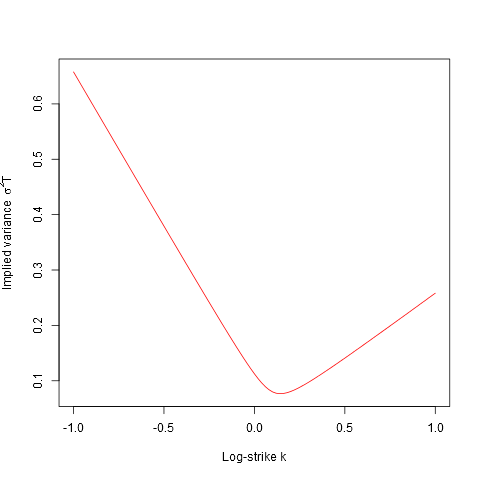

In [4]:
%%R

curve(svi(sviparams,x),from=-1,to=1,col="red",xlab="Log-strike k",ylab=expression(paste("Implied variance  ",sigma^2*T)));

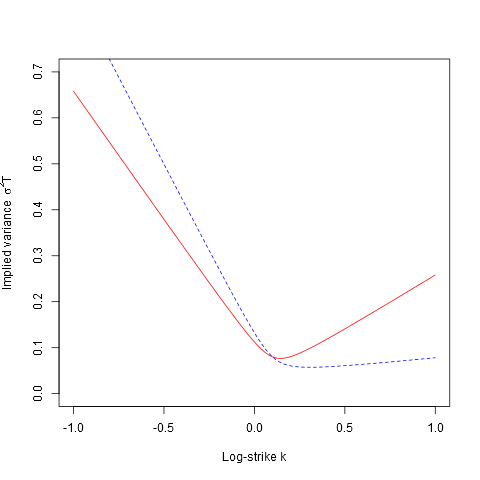

In [5]:
%%R 

sviparams <- list(a = 0.04, b = 0.4, sig = 0.1, rho = - 0.4, m = 0.1) 
curve(svi(sviparams,x),from=-1,to=1,col="red",xlab="Log-strike k",ylab=expression(paste("Implied variance  ",sigma^2*T)),
      ylim=c(0,.7)) 
sviparams2 <- sviparams 
sviparams2$rho <- sviparams$rho - 0.5 
curve(svi(sviparams2,x),from=-1,to=1,col="blue",add=T, lty=2)


In [6]:
%%R 
(sviJWparams <- sviToJw(sviparams,1))

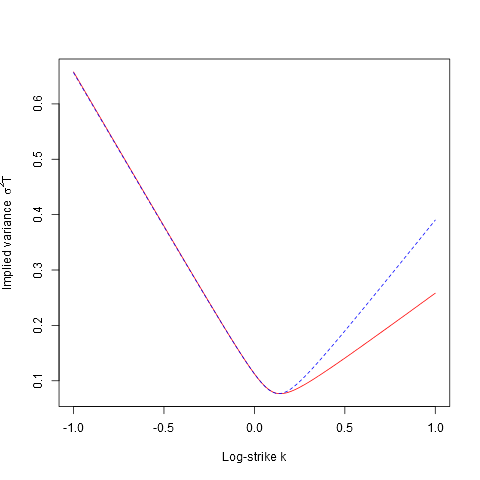

In [7]:
%%R 
curve(svi(sviparams,x),from=-1,to=1,col="red",xlab="Log-strike k",ylab=expression(paste("Implied variance  ",sigma^2*T))) 
sviJWparams2 <- sviJWparams 
sviJWparams2$ct <- sviJWparams$ct + .5 
sviparams2 <- jwToSvi(sviJWparams2) 
curve(svi(sviparams2,x),from=-1,to=1,col="blue",add=T, lty=2)


In [9]:
%%R 
# Butterfly g(.) function 
g <- function(sviparams,k){ 
    a <- sviparams$a;  
    b <- sviparams$b;  
    sig <- sviparams$sig;  
    rho <- sviparams$rho;  
    m <- sviparams$m;    
    discr <- sqrt((k-m)*(k-m) + sig*sig);
    w <- a + b *(rho*(k-m)+ discr);  
    dw <- b*rho + b *(k-m)/discr;  
    d2w <- b*sig^2/(discr*discr*discr);  
    return(1 - k*dw/w + dw*dw/4*(-1/w+k*k/(w*w)-4) +d2w/2); 
}

In [10]:
%%R 
a <- -0.0410 
b <- 0.1331 
m <- 0.3586 
rho <- 0.3060 
sig <- 0.4153 
vogtParams <- as.data.frame(list(a=a,b=b,m=m,rho=rho,sig=sig)) 
print(vogtJW <- sviToJw(vogtParams,1))  # SVI-JW parameters


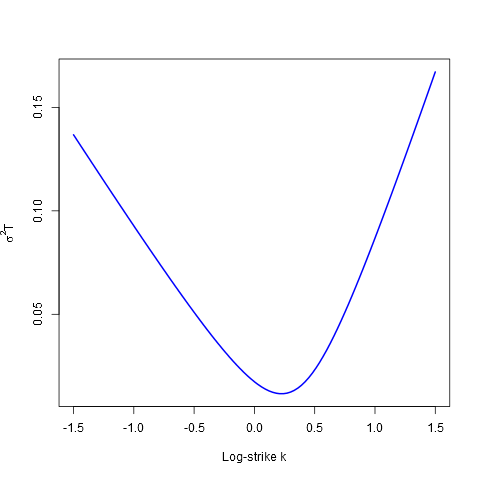

In [11]:
%%R 
# Plot Vogt smile (smileSVI) 
r <- 1.5 
curve(svi(vogtParams,x),from=-r,to=r,col="blue",lwd=2, ylab=expression(w=sigma^2*T),xlab="Log-strike k")


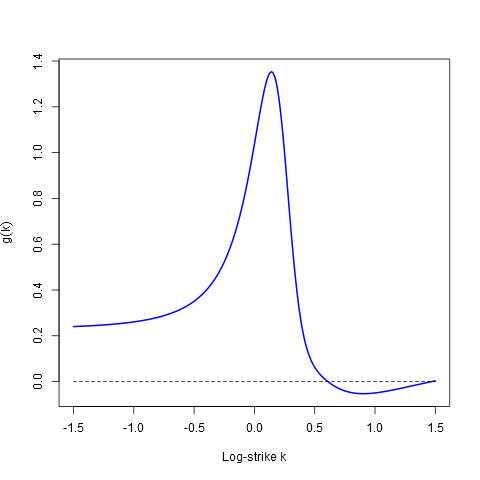

In [12]:
%%R 
curve(g(vogtParams,x),from=-r,to=r,col="blue",n=500,lwd=2,ylab=expression(g(k)), xlab="Log-strike k") 
lines(c(-r,r),c(0,0),lty=2)


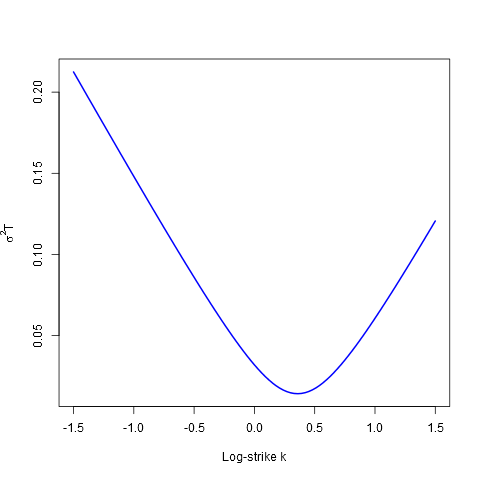

In [13]:
%%R 
vogtParams0 <- as.data.frame(list(a=a,b=b,m=m,rho=0,sig=sig)) 
# Plot Vogt smile (smileSVI) 
r <- 1.5 
curve(svi(vogtParams0,x),from=-r,to=r,col="blue",lwd=2, ylab=expression(w=sigma^2*T),xlab="Log-strike k")


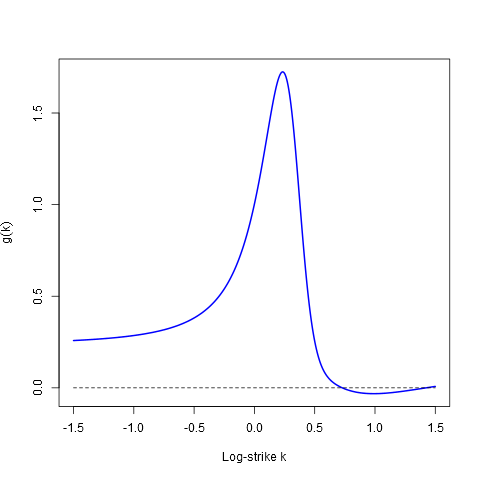

In [14]:
%%R 
# Plot graphs of g (ggraphSVI) 
curve(g(vogtParams0,x),from=-r,to=r,col="blue",n=500,lwd=2,ylab=expression(g(k)) ,xlab="Log-strike k") 
lines(c(-r,r),c(0,0),lty=2)


In [15]:
%%R 
t <- 1 
w <- a+b*(-rho*m + sqrt(m^2+sig^2)) 
v <- w/t 
psi <- 1/sqrt(w)*b/2*(-m/sqrt(m^2+sig^2)+rho) 
p <- 1/sqrt(w)*b*(1-rho) 
c <- 1/sqrt(w)*b*(1+rho) 
wtilde <- (a+b*sig*sqrt(1-rho^2)) 
vtilde <- wtilde/t 
cprime <- vogtJW$pt + 2*vogtJW$psit 
vtildeprime <- vogtJW$vt*4*vogtJW$pt*cprime/(vogtJW$pt+cprime)^2; 
vogtFixedJW <- vogtJW 
vogtFixedJW$ct <- cprime 
vogtFixedJW$varmint <- vtildeprime 
print(as.data.frame(rbind(vogtJW,vogtFixedJW))) 
# Convert SVI-JW parameters back to raw SVI parameters 
vogtFixedParams <- jwToSvi(vogtFixedJW) 
print(vogtFixedParams)


In [21]:
%%R 
# Now find values of ct and varmint that minimize distance from the original curve 
strikes <- (-10:10)/10;
print(strikes)
callVals <- function(sviparams,k){  
    BSFormula(1, exp(k), 1, 0, sigma=sqrt(svi(sviparams,k))) 
} 
callValsVogt <- callVals(vogtParams,strikes); 

obj <- function(par){  
    c <- par[1]  
    varmin <- par[2]  
    vogtNewJW <- vogtJW  
    vogtNewJW$ct <- c  
    vogtNewJW$varmint <- varmin  
    print(vogtNewJW)
    vogtNew <- jwToSvi(vogtNewJW)
    callValsNew <- callVals(vogtNew,strikes)
    # We need to also heavily penalize negative g  
    arbVal<- sviSliceArbitrageCompute(vogtNew)$gArb
    print((sum((callValsNew-callValsVogt)^2)+100*arbVal^2))
    return(sum((callValsNew-callValsVogt)^2)+100*arbVal^2)  
} 

obj(par=c(vogtJW$ct,vogtJW$varmint)) 
upperC=max(vogtJW$ct,vogtFixedJW$ct) 
lowerC=min(vogtJW$ct,vogtFixedJW$ct) 
upperV=max(vogtJW$varmint,vogtFixedJW$varmint) 
lowerV=min(vogtJW$varmint,vogtFixedJW$varmint)
res <- optim(par=c(vogtJW$ct,vogtJW$varmint),
             fn=obj, 
             method="BFGS",  
             lower=c(lowerC,lowerV), 
             upper=c(upperC,upperV)) 
vogtOptimalJW <- vogtJW 
print(vogtOptimalJW$ct <- res$par[1]) 
#[1] 0.8564763 
print(vogtOptimalJW$varmint <- res$par[2]) 
#[1] 0.0116249 
(vogtOptimalParams <- jwToSvi(vogtOptimalJW)) 
#            a         b       sig       rho         m 
#1 -0.03051988 0.1027168 0.4123978 0.1007176 0.2723441

In [18]:
%%R

tempJW <- vogtJW
tempJW$ct <- 0.899979
tempJW$varmint = 0.0137172

tempParams <- jwToSvi(tempJW)

print(g(tempParams, 0.64088))

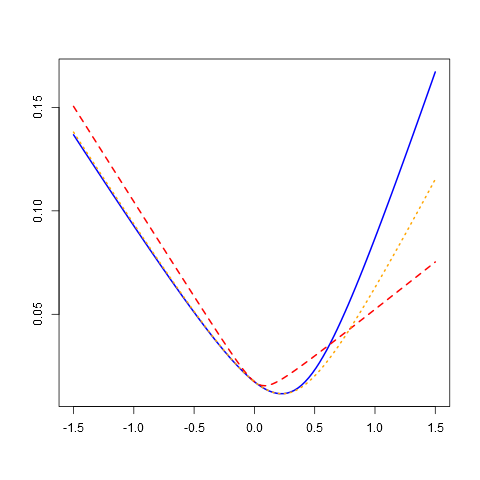

In [22]:
%%R 
# Plot Vogt smile (smileSVI) 
r <- 1.5 
curve(svi(vogtParams,x),from=-r,to=r,col="blue",lwd=2, ylab=NA,xlab=NA) 
ylab=expression(w=sigma^2*T) 
curve(svi(vogtFixedParams,x),from=-r,to=r,col="red",lwd=2,lty=2,add=T) 
curve(svi(vogtOptimalParams,x),from=-r,to=r,col="orange",lwd=2,lty=3,add=T)


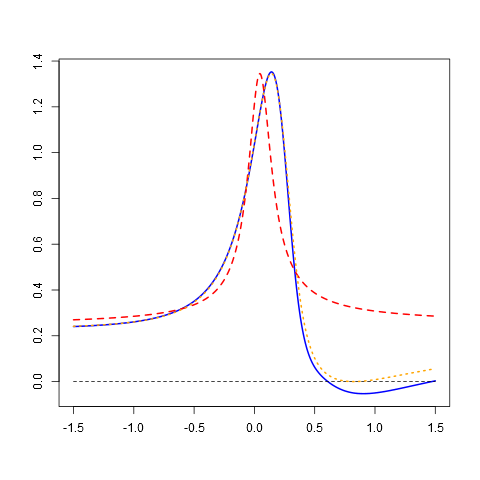

In [26]:
%%R 
# Plot graphs of g (ggraphSVI) 
curve(g(vogtParams,x),from=-r,to=r,col="blue",n=500,lwd=2,ylab=NA,xlab=NA) 
lines(c(-r,r),c(0,0),lty=2); 
curve(g(vogtFixedParams,x),from=-r,to=r,col="red",n=500,add=T,lwd=2,lty=2) 
curve(g(vogtOptimalParams,x),from=-r,to=r,col="orange",n=500,add=T,lwd=2,lty=3)
print(sviSliceArbitrageCompute(vogtOptimalParams)$gArb)